# Analyse de sentiments 

In [1]:
import codecs
import re
import string
import unicodedata
import os

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !python3 -m spacy download en_core_web_lg

In [3]:
STOP_WORDS = stopwords.words("english")
nlp = spacy.load("en_core_web_lg")

# Chargement des données

In [4]:
def load_movies(path2data):  # 1 classe par répertoire
    alltxts = []  # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt += 1  # chg répertoire = cht classe

    return alltxts, labs

In [5]:
path = "./datasets/movies/movies1000/"
alltxts, alllabs = load_movies(path)

In [6]:
print(len(alltxts), len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

2000 2000
the word to describe sharon stone is " wonder " . 
not that she _is_ a wonder , but rather that i wonder how she can be so inconsistent . 
she has a dynamic screen presence in " basic instinct " , turns in a surprisingly fine acting job in " casino " , but possesses neither of those here . 
stone teams up with private school headmaster's wife isabelle adjani to kill adjani's thoroughly unlikable husband ( chazz palminteri ) . 
in a comedy of errors and unexpected twists straight out of hitchcock ( as in `homage to' [read " steal from " ] ) , it turns out that someone saw them or he's not dead or maybe . . . 
kathy bates turns in a credible , if unspectacular , performance as an investigative police detective . 
her character is a bit dull but realistic , although her actions at the end are puzzling . 
adjani is more than satisfactory as the timid beaten spouse driven to desperation . 
it's stone that is a disappointment among the actors . 
how can she be the epitome of a femm

In [7]:
np.unique(alllabs)  # nos labels

array([0, 1])

## A) Transformation paramétrique du texte (pre-traitements)

- Train/Test split des données : 

In [8]:
index = np.arange(len(alltxts))
Xtrain, Xtest, ytrain, ytest = train_test_split(
    alltxts, alllabs, stratify=alllabs)

- Appliquer une lemmatisation sur la base d'entrainement (Pour des questions d'optimisation)

In [9]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    docs = list(nlp.pipe(tokens, disable=["parser", "ner"]))
    tokens_lem = [doc[0].lemma_ for doc in docs]
    text = ' '.join(tokens_lem)
    return text


def lemmatize_data(data):
    lemmatize_text_vec = np.vectorize(lemmatize_text)
    data_lem = lemmatize_text_vec(data)
    return data_lem


if "Xtrain_lem" not in globals():
    Xtrain_lem = lemmatize_data(Xtrain)

In [10]:
def preprocess_strat(text, X):

    punc = string.punctuation
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))

    text = unicodedata.normalize('NFD', text).encode(
        'ascii', 'ignore').decode("utf-8")
    text = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', text)

    if X["ToLower"]:
        text = text.lower()

    if X["DeleteNumbers"]:
        text = re.sub('[0-9]+', '', text)

    return text


def fit(X, force_count_vec=False):
    preprocess = None
    stopwords = None
    ngram_range = (1, 1)
    use_idf = True
    min_df = 1
    max_df = 1.0
    max_features = None
    binary = False
    data = Xtrain
    count_vec = True

    if X is not None:
        def preprocess(text): return preprocess_strat(text, X)

        if "stopwords" in X:
            stopwords = X["stopwords"]
        if "ngram_range" in X:
            ngram_range = X["ngram_range"]
        if "use_idf" in X:
            use_idf = X["use_idf"]
        if "min_df" in X:
            min_df = X["min_df"]
        if "max_df" in X:
            max_df = X["max_df"]
        if "max_features" in X:
            max_features = X["max_features"]
        if "binary" in X:
            binary = X["binary"]
        if "lemmatized" in X and X["lemmatized"]:
            data = Xtrain_lem
        
        if not force_count_vec and "count_vec" in X:
            count_vec = X["count_vec"]

    if count_vec:
        vectorizer = CountVectorizer(
            preprocessor=preprocess, stop_words=stopwords)
        return vectorizer.fit_transform(data), vectorizer

    vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords, ngram_range=ngram_range, use_idf=use_idf,
                                 min_df=min_df, max_df=max_df, max_features=max_features, binary=binary)

    return vectorizer.fit_transform(data), vectorizer

In [11]:
X1 = {
    "name": "Lower | Not Number | Stop Words",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "lemmatized": True,
    "count_vec": False,
}

In [12]:
strats = [X1]

# B) Extraction du vocabulaire (BoW)
- **Exploration préliminaire des jeux de données**
    



In [13]:
X_base, vectorizer = fit(None)

In [14]:
vectorizer.get_feature_names_out()

array(['00', '000', '0009f', ..., 'zwigoff', 'zycie', 'zzzzzzz'],
      dtype=object)

Quelle est la taille d'origine du vocabulaire?

In [15]:
X_base.shape[1]

35645

In [16]:
def get_wordcloud(X, count_vec, odd_ratio=False):

    vectors, vectorizer = fit(X, force_count_vec=count_vec)

    if not odd_ratio:
        counts = np.array(vectors.sum(axis=0))[0]
    else:
        # Classe 1
        p = np.array(vectors[ytrain == 1].sum(axis=0))[0]
        # Classe -1
        q = np.array(vectors[ytrain == 0].sum(axis=0))[0]

        odds1 = p * (1 - q)
        odds2 = q * (1 - p)

        odds_ratio = np.where(odds2 == 0, 0, odds1 / odds2)

    dico = dict()
    words = vectorizer.get_feature_names_out()

    for i in range(len(words)):
        w = words[i]
        if not odd_ratio:
            dico[w] = counts[i]
        else:
            dico[w] = odds_ratio[i]

    return WordCloud(background_color='white', stopwords=[],
                     max_words=100).generate_from_frequencies(dico)

Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

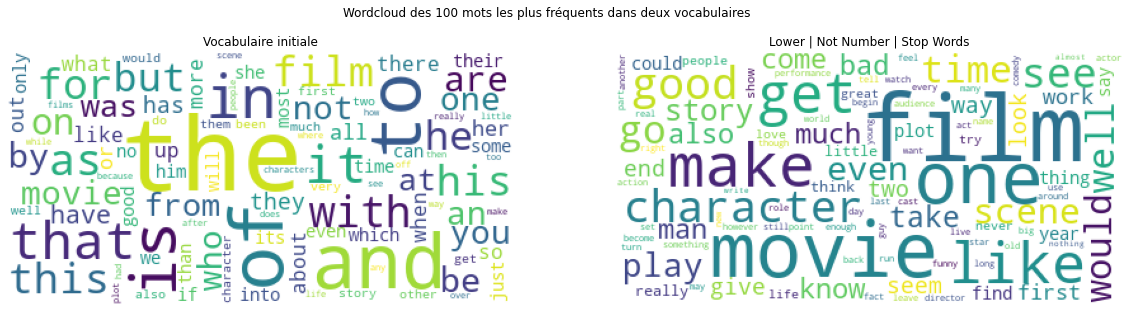

In [17]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=True)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=True)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.suptitle("Wordcloud des 100 mots les plus fréquents dans deux vocabulaires")
plt.show()

Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

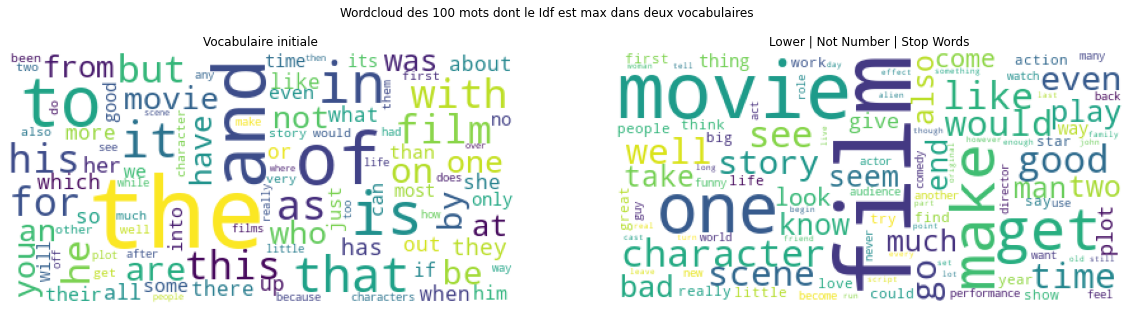

In [18]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=False)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=False)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.suptitle("Wordcloud des 100 mots dont le Idf est max dans deux vocabulaires")
plt.show()

Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

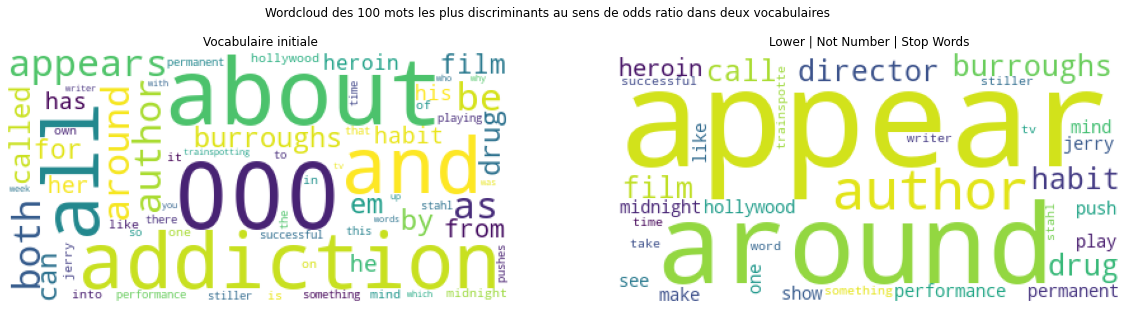

In [19]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=True, odd_ratio=True)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=True, odd_ratio=True)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.suptitle("Wordcloud des 100 mots les plus discriminants au sens de odds ratio dans deux vocabulaires")
plt.show()

Quelle est la distribution d'apparition des mots (Zipf)

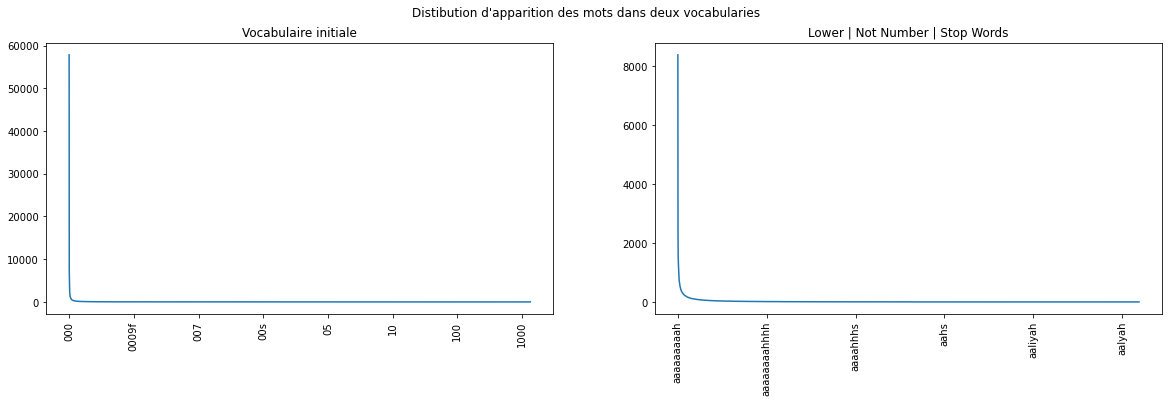

In [20]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

vectors, vectorizer = fit(None, force_count_vec=True)
counts = np.array(vectors.sum(axis=0))[0]
index = counts.argsort()[::-1]
axs[0].plot(counts[index])
axs[0].set_title('Vocabulaire initiale')
axs[0].set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)

for i, X in enumerate(strats):
    vectors, vectorizer = fit(X, force_count_vec=True)
    counts = np.array(vectors.sum(axis=0))[0]
    index = counts.argsort()[::-1]
    axs[i+1].plot(counts[index])
    axs[i+1].set_title(X["name"])
    axs[i+1].set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)

plt.suptitle("Distibution d'apparition des mots dans deux vocabularies")
plt.show()

Quels sont les 100 bigrammes/trigrammes les plus fréquents?

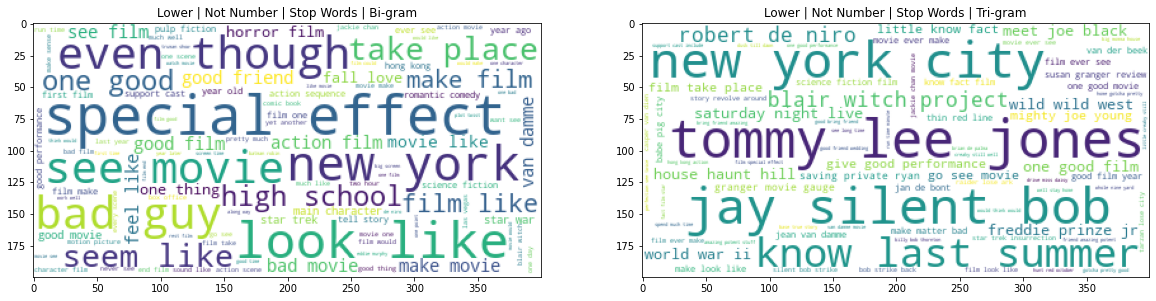

In [21]:
X_bi = {
    "name": "Lower | Not Number | Stop Words | Bi-gram",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "ngram_range": (2, 2),
    "lemmatized": True,
    "count_vec": False,
}

X_tri = {
    "name": "Lower | Not Number | Stop Words | Tri-gram",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "ngram_range": (3, 3),
    "lemmatized": True,
    "count_vec": False,
}
    
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, X in enumerate([X_bi, X_tri]):
    wordcloud = get_wordcloud(X, count_vec=False)
    axs[i].imshow(wordcloud)
    axs[i].set_title(X["name"])

plt.show()

- **Variantes de BoW**

In [22]:
strats = []

strats.append({
    "name": "Lower | Not Number | Stop Words | TF",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "use_idf": False,
    "lemmatized": True,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | TF",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "lemmatized": True,
    "count_vec": True,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | min_max_df",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "min_df": 10,
    "max_df": 0.93,
    "lemmatized": True,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | min_max_df",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "min_df": 6,
    "max_df": 0.95,
    "lemmatized": True,
    "max_features": 10000,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | Binary",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "binary": True,
    "lemmatized": True,
    "count_vec": False,
})

strats.append({
    "name": "Lower | Not Number | Stop Words | Bi-gram",
    "ToLower": True,
    "DeleteNumbers": True,
    "stopwords": STOP_WORDS,
    "ngram_range": (2, 2),
    "lemmatized": True,
    "count_vec": False,
    "min_df": 7,
    "max_df": 0.95,
})

In [23]:
for X in strats:
    vectors, vectorizer = fit(X)
    X["base"] = vectors
    X["vectorizer"] = vectorizer

# C) Modèles de Machine Learning

In [24]:
def eval_model(labels, y_hat):
    scores = {}
    scores["f1_score"] = f1_score(labels, y_hat)
    scores["accuracy"] = accuracy_score(labels, y_hat)
    scores["auc_roc"] = roc_auc_score(labels, y_hat)
    return scores

In [25]:
if "Xtest_lem" not in globals():
    Xtest_lem = lemmatize_data(Xtest)

In [26]:
def optimize_strats(lstrats, optimizer, model_name, sample, scoring="f1_macro"):
    
    if sample is not None:
            model_name = f"{model_name}_{sample}"
            
    for X in tqdm(lstrats):            
        X[model_name] = optimizer(X, scoring=scoring, sample=sample)

In [27]:
def get_scores(lstrats, model_name, sample):
    
    if sample is not None:
        model_name = f"{model_name}_{sample}"
        
    for X in tqdm(lstrats):
        Xtest_tran = X["vectorizer"].transform(Xtest_lem)
        y_hat = X[model_name].predict(Xtest_tran)
        X[f"scores_{model_name}"] = eval_model(ytest, y_hat)
        precision, recall, _, _ = precision_recall_fscore_support(ytest, y_hat)
        X[f"precision_{model_name}"] = precision
        X[f"recall_{model_name}"] = recall

In [28]:

def lineplot(scores, ax, score_name):
    sns.lineplot(x=list(range(1, len(scores)+1)),
                y=scores, color='steelblue', ax=ax, linestyle='--', marker='o')
    
    ax.set_xlabel('Numéro de la strategie')
    ax.set_ylabel(score_name)
    ax.set_title(f'Distribution des scores {score_name}')

def optimization_report(lstrats, model_name, sample):
    f1_scores = []
    accuracy_scores = []
    roc_auc_scores = []

    if sample is not None:
        model_name = f"{model_name}_{sample}"
        
    scores_names = f"scores_{model_name}"

    for i, X in enumerate(lstrats):
        f1_scores.append(X[scores_names]['f1_score'])
        accuracy_scores.append(X[scores_names]['accuracy'])
        roc_auc_scores.append(X[scores_names]['auc_roc'])
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    lineplot(f1_scores, axs[0], "F1 score")
    lineplot(accuracy_scores, axs[1], "Accuracy")
    lineplot(roc_auc_scores, axs[2], "AUC-ROC")
    plt.tight_layout()
    plt.show()

In [29]:
def reglog_optimizer(X, sample, scoring='f1_macro'):
    reglog = LogisticRegression(max_iter=2000, class_weight="balanced")
    params = {'C': [0.01, 0.1, 0.5, 1, 2], 'penalty': ['l2', None]}
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    grid = GridSearchCV(reglog, params, cv=cv, n_jobs=-1, scoring=scoring)
    
    if sample is None:
        grid.fit(X["base"], ytrain)
    else:
        grid.fit(X[f"X_{sample}"], X[f"y_{sample}"])
        
    return grid.best_estimator_

In [30]:
optimize_strats(strats, reglog_optimizer, "reglog", None)

100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


In [31]:
get_scores(strats, "reglog", None)

100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


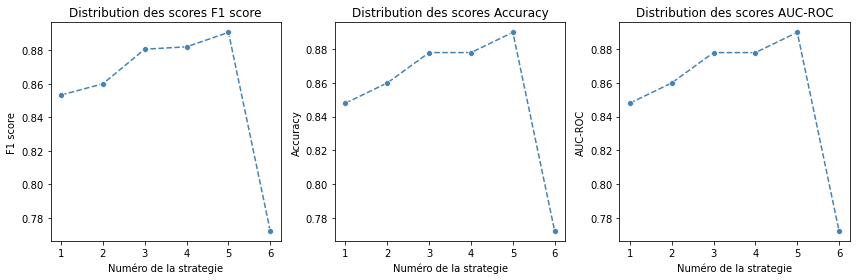

In [32]:
optimization_report(strats, "reglog", None)

In [33]:
def rf_optimizer(X, sample, n_estimators=100, scoring='f1_macro'):
    rf = RandomForestClassifier(
        n_estimators=n_estimators, class_weight='balanced')
    params = {'max_depth': [5, 7, 12], 'min_samples_split': [5, 10, 20, 30]}
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    grid = RandomizedSearchCV(rf, params, cv=cv, n_jobs=-1, scoring=scoring)
    
    if sample is None:
        grid.fit(X["base"], ytrain)
    else:
        grid.fit(X[f"X_{sample}"], X[f"y_{sample}"])
        
    return grid.best_estimator_

In [34]:
optimize_strats(strats, rf_optimizer, "rf", None)

100%|██████████| 6/6 [00:24<00:00,  4.11s/it]


In [35]:
get_scores(strats, "rf", None)

100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


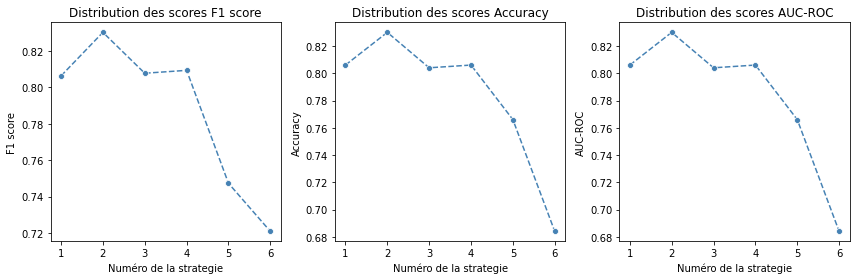

In [36]:
optimization_report(strats, "rf", None)

In [37]:
def nb_optimizer(X, sample, scoring=None):
    nb = MultinomialNB()
        
    if sample is None:
        nb.fit(X["base"], ytrain)
    else:
        nb.fit(X[f"X_{sample}"], X[f"y_{sample}"])
        
    return nb

In [38]:
optimize_strats(strats, nb_optimizer, "nb", None)
get_scores(strats, "nb", None)

100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


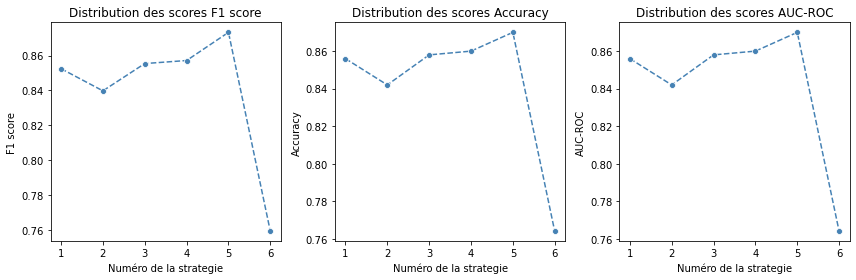

In [39]:
optimization_report(strats, "nb", None)

In [40]:
def svm_optimizer(X, sample, scoring="f1_macro"):
    svm = LinearSVC(class_weight='balanced', max_iter=4000)
    params = {'C': [0.001, 0.1, 0.5, 1, 1.5], 'penalty': ["l1", "l2"]}
    
    cv = StratifiedKFold(n_splits=4, shuffle=True)
    grid = RandomizedSearchCV(svm, params, cv=cv, n_jobs=-1, scoring=scoring)
        
    if sample is None:
        grid.fit(X["base"], ytrain)
    else:
        grid.fit(X[f"X_{sample}"], X[f"y_{sample}"])
    
    return grid.best_estimator_

In [41]:
optimize_strats(strats, svm_optimizer, "svm", None)
get_scores(strats, "svm", None)

100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


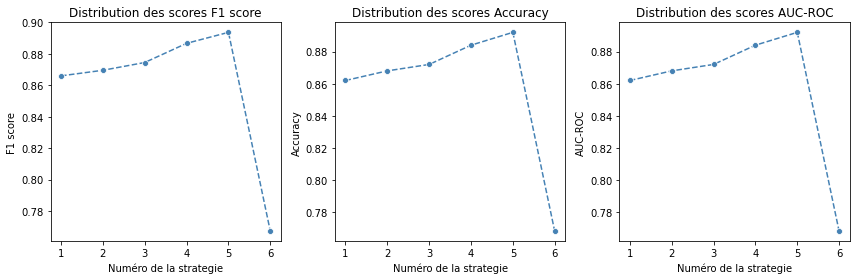

In [42]:
optimization_report(strats, "svm", None)

## Test

In [43]:
strat_max  = None
model_max  = None
sample_max = None
score_max  = 0

for X in strats:
    for model in ["reglog", "svm", "rf", "nb"]:
        for sample in ["", "_over", "_under"]:
            
            if f"scores_{model}{sample}" in X:
                score = (X[f"scores_{model}{sample}"]["f1_score"] + X[f"scores_{model}{sample}"]["auc_roc"]) / 2
            
                if score > score_max:
                    score_max = score
                    strat_max = X
                    model_max = model
                    sample_max = sample

In [44]:
def load_movies_test(filename):
    
    with open(filename, "r") as f:
        testtxts = f.readlines()

    return np.array(testtxts)

In [45]:
fname = "./datasets/movies/testSentiment.txt"
testtxts = load_movies_test(fname)
testtxts.shape

(25000,)

In [52]:
if "Xval_lem" not in globals():
    Xval_lem = lemmatize_data(testtxts)

- Max (f1_score + auc_roc) / 2

In [53]:
X_lem = np.concatenate((Xtrain_lem.reshape(-1, ), Xtest_lem.reshape(-1, )), axis=0)
y_lem = np.concatenate((np.array(ytrain).reshape(-1, ), np.array(ytest).reshape(-1, )), axis=0)

In [54]:
X_lem_trans = strat_max["vectorizer"].transform(X_lem)
strat_max[f"{model_max}{sample_max}"].fit(X_lem_trans, y_lem)

LinearSVC(C=0.5, class_weight='balanced', max_iter=4000)

In [55]:
Xval_tran = strat_max["vectorizer"].transform(Xval_lem)
y_hat = strat_max[f"{model_max}{sample_max}"].predict(Xval_tran)

In [56]:
with open("push_1", "w") as f:
    f.write("\n".join(np.where(y_hat == 0, "N", "P")))